# Project on skin cancer detection

## Importing libraries

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Reading input data

In [4]:
dir_test=pathlib.Path("C:/Users/rakes/Skin_Cancer_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
dir_train=pathlib.Path("C:/Users/rakes/Skin_Cancer_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [5]:
image_count_train=len(list(dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test=len(list(dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Prepare the dataset

In [6]:
batch_size=32
img_height=180
img_width=180

### using 80:20 ratio for training and validation

In [7]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
class_names=train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data

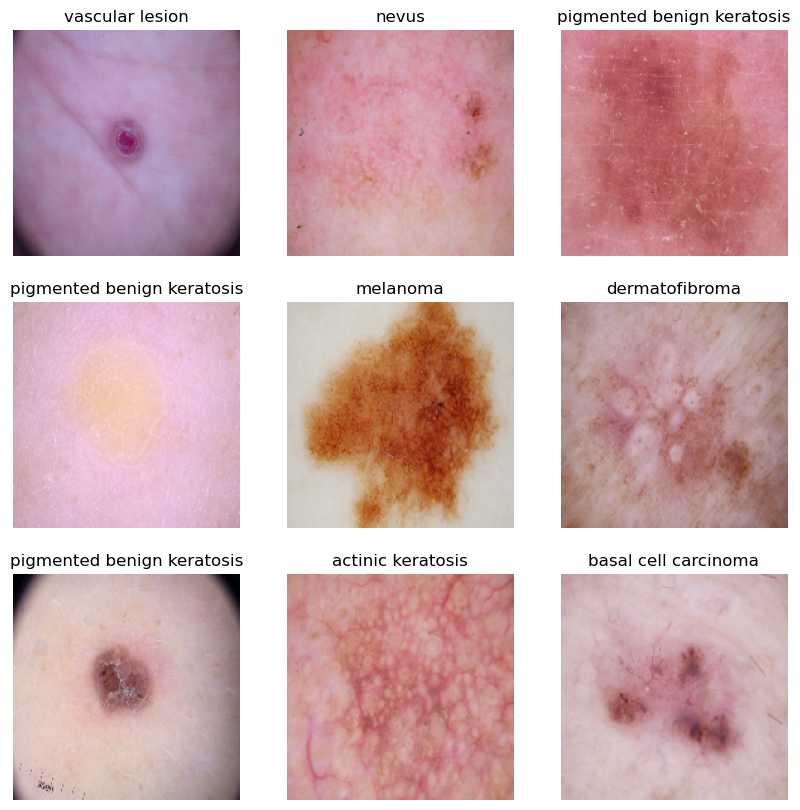

In [10]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
AUTOTUNE= tf.data.experimental.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_df= val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating a CNN model

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
num_classes=9
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the model

In [13]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [15]:
epochs=20
history= model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 236ms/step - loss: 2.1642 - accuracy: 0.2059 - val_loss: 1.9845 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 12s 216ms/step - loss: 1.8674 - accuracy: 0.3298 - val_loss: 1.7812 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 12s 219ms/step - loss: 1.6244 - accuracy: 0.4280 - val_loss: 1.5271 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 12s 210ms/step - loss: 1.4698 - accuracy: 0.4721 - val_loss: 1.5581 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 12s 213ms/step - loss: 1.3628 - accuracy: 0.5262 - val_loss: 1.4579 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 13s 225ms/step - loss: 1.2686 - accuracy: 0.5569 - val_loss: 1.4304 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 11s 204ms/step - loss: 1.2505 - accuracy: 0.5653 - val_loss: 1.4423 - val_accuracy: 0.5235

## Visualizing training results

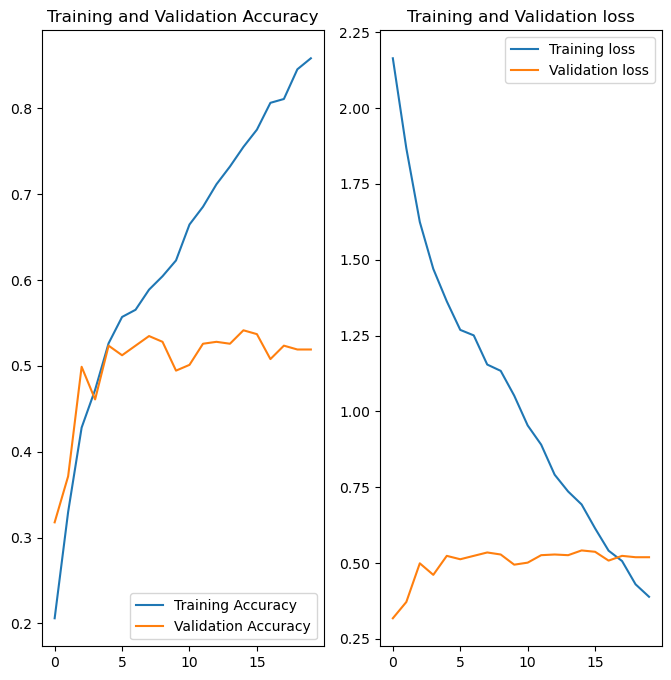

In [16]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_acc,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

## Overcoming the problem of overfitting by agumentation

In [17]:
data_augmentation= keras.Sequential([
                        layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
                        layers.experimental.preprocessing.RandomRotation(0.1),
                        layers.experimental.preprocessing.RandomZoom(0.1),
])

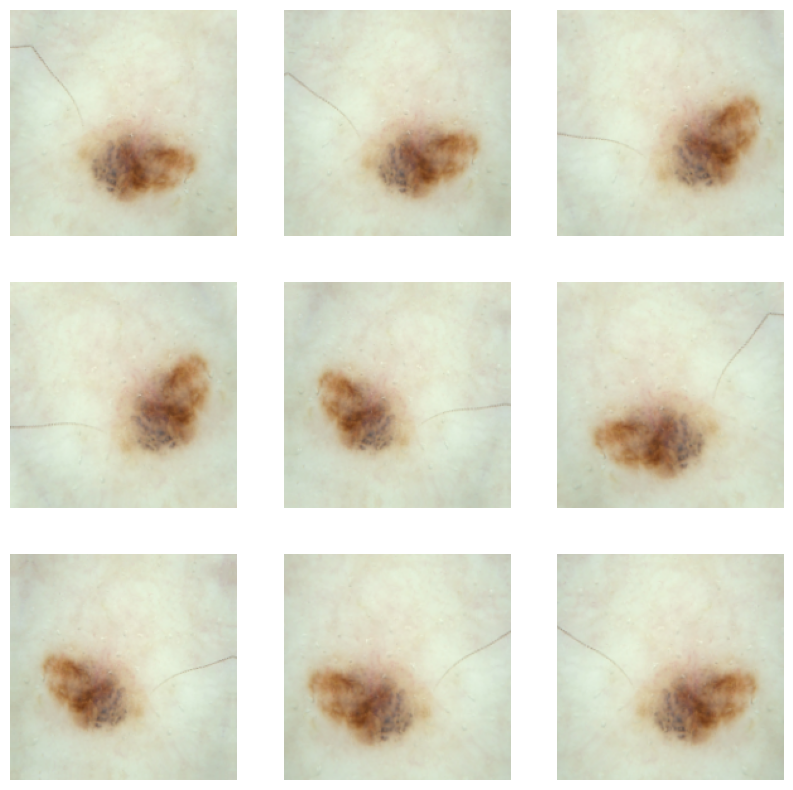

In [19]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
        for i in range(9):
            augmented_images= data_augmentation(images)
            ax= plt.subplot(3,3,i+1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

## create model, compile and train the model

In [20]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compiling the model

In [21]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

## Training the model

In [22]:
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs= epochs
)

Epoch 1/20
56/56 [==============================] - 30s 410ms/step - loss: 2.1931 - accuracy: 0.2093 - val_loss: 2.0081 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 23s 413ms/step - loss: 1.9481 - accuracy: 0.2729 - val_loss: 2.1941 - val_accuracy: 0.1991
Epoch 3/20
56/56 [==============================] - 23s 404ms/step - loss: 1.7494 - accuracy: 0.3683 - val_loss: 1.6370 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 22s 398ms/step - loss: 1.6350 - accuracy: 0.4096 - val_loss: 1.6043 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 23s 409ms/step - loss: 1.5843 - accuracy: 0.4152 - val_loss: 1.5674 - val_accuracy: 0.4430
Epoch 6/20
56/56 [==============================] - 23s 405ms/step - loss: 1.5153 - accuracy: 0.4626 - val_loss: 1.5407 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 23s 412ms/step - loss: 1.4825 - accuracy: 0.4855 - val_loss: 1.6887 - val_accuracy: 0.4452

## Visualizing the results again

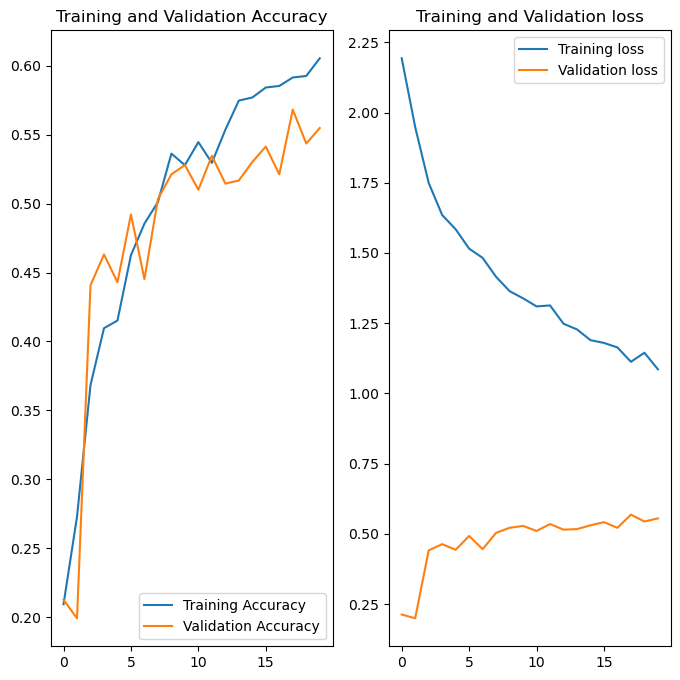

In [23]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_acc,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [24]:
import os
from glob import glob
path_list=[x for x in glob(os.path.join(dir_train,'*','*.jpg'))]
lesion_list=[os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(dir_train,'*','*.jpg'))]
print(len(lesion_list))

2239


In [25]:

df_dict_original= dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('C:\\Users\\rakes\\Skin_Cancer_detection\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('C:\\Users\\rakes\\Skin_Cancer_detection\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis')]


In [26]:
import pandas as pd
original_df=pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
1,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
2,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
3,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
4,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis


In [27]:
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [28]:
original_df[['Label']].value_counts(normalize=True)

Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
dtype: float64

In [29]:
!pip install Augmentor

In [30]:
path_to_training_dataset= str(dir_train)+'/'
import Augmentor
for i in class_names:
    p= Augmentor.Pipeline(path_to_training_dataset+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x233AF267D60>: 100%|██████████| 500/500 [00:03<00:00, 137.01 Samples/s]


Initialised with 376 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x233AD402BB0>: 100%|██████████| 500/500 [00:03<00:00, 133.45 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x233AEC4C970>: 100%|██████████| 500/500 [00:03<00:00, 132.10 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x233AEC85100>: 100%|██████████| 500/500 [00:19<00:00, 25.16 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x233ABC35F40>: 100%|██████████| 500/500 [00:15<00:00, 31.50 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x233AD3F77C0>: 100%|██████████| 500/500 [00:03<00:00, 129.62 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x233ABC30EB0>: 100%|██████████| 500/500 [00:08<00:00, 56.07 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x23351631DC0>: 100%|██████████| 500/500 [00:04<00:00, 120.87 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\rakes\Skin_Cancer_detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x233ABF52670>: 100%|██████████| 500/500 [00:03<00:00, 125.42 Samples/s]


In [31]:
image_count_train= len(list(dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Distribution of augmented data after adding new images

In [32]:
path_list_new= [x for x in glob(os.path.join(dir_train,'*','output','*.jpg'))]
path_list_new[:2]

['C:\\Users\\rakes\\Skin_Cancer_detection\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_25507e08-5673-483c-8257-53d4637c4670.jpg',
 'C:\\Users\\rakes\\Skin_Cancer_detection\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_30a11cb0-e05e-4384-ad71-4a3dc97f7e4b.jpg']

In [33]:
lesion_list_new=[os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(dir_train,'*','output','*.jpg'))]
lesion_list_new[:2]

['actinic keratosis', 'actinic keratosis']

In [34]:
dataframe_dict_new= dict(zip(path_list_new, lesion_list_new))

In [35]:
df2= pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path','Label'])
new_df= original_df.append(df2)
new_df.shape

(6739, 2)

In [36]:
new_df.head()

,Path,Label
0,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
1,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
2,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
3,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis
4,C:\Users\rakes\Skin_Cancer_detection\Skin canc...,actinic keratosis


In [37]:
new_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

## Now again train the model on the data created using augmentor

In [39]:
batch_size=32
img_height=180
img_width=180

In [40]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [41]:
val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [44]:
epochs=30
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs= epochs
)

Epoch 1/30
169/169 [==============================] - 76s 403ms/step - loss: 1.7677 - accuracy: 0.3257 - val_loss: 1.4607 - val_accuracy: 0.4655
Epoch 2/30
169/169 [==============================] - 67s 392ms/step - loss: 1.4317 - accuracy: 0.4503 - val_loss: 1.3511 - val_accuracy: 0.4937
Epoch 3/30
169/169 [==============================] - 68s 398ms/step - loss: 1.3132 - accuracy: 0.4961 - val_loss: 1.2470 - val_accuracy: 0.5174
Epoch 4/30
169/169 [==============================] - 68s 399ms/step - loss: 1.2077 - accuracy: 0.5395 - val_loss: 1.1340 - val_accuracy: 0.5828
Epoch 5/30
169/169 [==============================] - 66s 390ms/step - loss: 1.1376 - accuracy: 0.5684 - val_loss: 1.3285 - val_accuracy: 0.5145
Epoch 6/30
169/169 [==============================] - 69s 404ms/step - loss: 1.0815 - accuracy: 0.5814 - val_loss: 1.0955 - val_accuracy: 0.5828
Epoch 7/30
169/169 [==============================] - 69s 408ms/step - loss: 0.9800 - accuracy: 0.6272 - val_loss: 0.9155 - val_ac

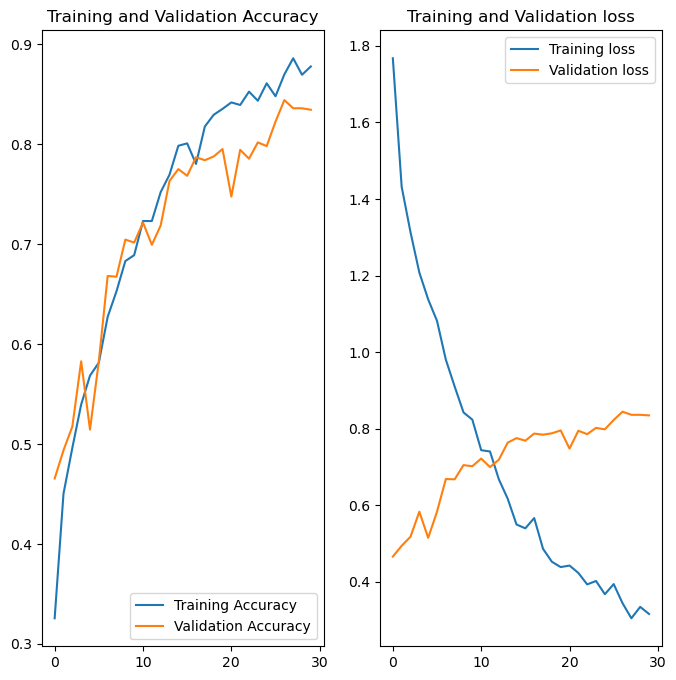

In [45]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_acc,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [54]:
model.save('my_model.h6')

INFO:tensorflow:Assets written to: my_model.h6\assets


INFO:tensorflow:Assets written to: my_model.h6\assets


In [46]:
import pickle

In [47]:
filename='skin_disease_model'
pickle.dump(model,open(filename,'wb'))

INFO:tensorflow:Assets written to: ram://1d2cfc65-b715-48c3-a358-3e4b7ec0a89f/assets


INFO:tensorflow:Assets written to: ram://1d2cfc65-b715-48c3-a358-3e4b7ec0a89f/assets
